### colab setup

<a href="https://colab.research.google.com/github/e-cremente/physioex/blob/main/examples/freq_bands_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# colab setup
from google.colab import drive
drive.mount("/content/drive")

import os
working_dir = "/content/drive/MyDrive/Thesis"
os.chdir( working_dir )

!git clone https://github.com/e-cremente/physioex.git
%cd physioex

!git pull origin main
!pip install -e .

Mounted at /content/drive
fatal: destination path 'physioex' already exists and is not an empty directory.
/content/drive/MyDrive/Thesis/physioex
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 6), reused 9 (delta 5), pack-reused 0
Unpacking objects: 100% (10/10), 1.28 KiB | 1024 bytes/s, done.
From https://github.com/e-cremente/physioex
 * branch            main       -> FETCH_HEAD
   dca907e..14b4eb1  main       -> origin/main
Updating dca907e..14b4eb1
Fast-forward
 physioex/explain/freq_bands_explainer.py | 134 +++++++++++++++++++++++++++++++--------------------
 1 file changed, 82 insertions(+), 52 deletions(-)
Obtaining file:///content/drive/MyDrive/Thesis/physioex
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.8/563.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 15.8 MB/s eta 0:00:00
     ━━

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from physioex.explain.freq_bands_explainer import FreqBandsExplainer
from loguru import logger

ckp_path = "models/cel/chambon2018/seqlen=3/dreem/dodh/"

expl = FreqBandsExplainer(
            model_name = "chambon2018",
            dataset_name  = "dreem",
            version = "dodh",
            use_cache = True,
            sequence_lenght  = 3,
            ckp_path = ckp_path,
            batch_size  = 32,
            )

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions 

2024-01-28 11:26:53.980 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:162 - JOB:0-Loading model <class 'physioex.train.networks.chambon2018.Chambon2018Net'> from checkpoint models/cel/chambon2018/seqlen=3/dreem/dodh/fold=0-epoch=8-step=5030-val_acc=0.87.ckpt
2024-01-28 11:26:55.122 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:167 - JOB:0-Splitting dataset into train, validation and test sets
2024-01-28 11:26:55.384 | INFO     | physioex.data.dreem:split:198 - Train shape X (19019, 1, 3000), y (19019,)
2024-01-28 11:26:55.386 | INFO     | physioex.data.dreem:split:199 - Valid shape X (3714, 1, 3000), y (3714,)
2024-01-28 11:26:55.388 | INFO     | physioex.data.dreem:split:200 - Test shape X (1929, 1, 3000), y (1929,)
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_pro

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 11:43:08.068 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:0-Plotting band Alpha simple importance for true label
2024-01-28 11:43:08.555 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:0-Plotting band Alpha weighted importance for true label
2024-01-28 11:43:09.041 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:0-Plotting band Alpha normalized importance for true label
2024-01-28 11:43:09.515 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:0-Plotting band Alpha simple importance for predicted label
2024-01-28 11:43:09.973 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:0-Plotting band Alpha weighted importance for predicted label
2024-01-28 11:43:10.451 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:0-Plotting band Alpha normalized importance for predi

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 12:00:02.643 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:1-Plotting band Alpha simple importance for true label
2024-01-28 12:00:03.228 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:1-Plotting band Alpha weighted importance for true label
2024-01-28 12:00:03.694 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:1-Plotting band Alpha normalized importance for true label
2024-01-28 12:00:04.147 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:1-Plotting band Alpha simple importance for predicted label
2024-01-28 12:00:04.633 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:1-Plotting band Alpha weighted importance for predicted label
2024-01-28 12:00:05.146 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:1-Plotting band Alpha normalized importance for predi

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
2024-01-28 12:16:46.213 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:2-Plotting band Alpha simple importance for true label


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 12:16:46.664 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:2-Plotting band Alpha weighted importance for true label
2024-01-28 12:16:47.572 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:2-Plotting band Alpha normalized importance for true label
2024-01-28 12:16:48.028 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:2-Plotting band Alpha simple importance for predicted label
2024-01-28 12:16:48.539 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:2-Plotting band Alpha weighted importance for predicted label
2024-01-28 12:16:49.029 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:2-Plotting band Alpha normalized importance for predicted label
2024-01-28 12:16:49.510 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:2-Plotting band Sigma simple importance for 

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
2024-01-28 12:32:52.406 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:3-Plotting band Alpha simple importance for true label


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 12:32:52.879 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:3-Plotting band Alpha weighted importance for true label
2024-01-28 12:32:53.332 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:3-Plotting band Alpha normalized importance for true label
2024-01-28 12:32:54.391 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:3-Plotting band Alpha simple importance for predicted label
2024-01-28 12:32:54.912 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:3-Plotting band Alpha weighted importance for predicted label
2024-01-28 12:32:55.321 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:3-Plotting band Alpha normalized importance for predicted label
2024-01-28 12:32:55.798 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:3-Plotting band Sigma simple importance for 

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
2024-01-28 12:49:05.256 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:5-Plotting band Alpha simple importance for true label


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 12:49:05.729 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:5-Plotting band Alpha weighted importance for true label
2024-01-28 12:49:06.211 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:5-Plotting band Alpha normalized importance for true label
2024-01-28 12:49:06.704 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:5-Plotting band Alpha simple importance for predicted label
2024-01-28 12:49:07.148 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:5-Plotting band Alpha weighted importance for predicted label
2024-01-28 12:49:07.607 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:5-Plotting band Alpha normalized importance for predicted label
2024-01-28 12:49:08.088 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:5-Plotting band Sigma simple importance for 

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
2024-01-28 13:05:38.957 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:4-Plotting band Alpha simple importance for true label


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 13:05:39.489 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:4-Plotting band Alpha weighted importance for true label
2024-01-28 13:05:39.952 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:4-Plotting band Alpha normalized importance for true label
2024-01-28 13:05:40.475 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:4-Plotting band Alpha simple importance for predicted label
2024-01-28 13:05:40.938 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:4-Plotting band Alpha weighted importance for predicted label
2024-01-28 13:05:41.387 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:4-Plotting band Alpha normalized importance for predicted label
2024-01-28 13:05:41.820 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:4-Plotting band Sigma simple importance for 

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
2024-01-28 13:22:10.075 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:6-Plotting band Alpha simple importance for true label


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 13:22:10.562 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:6-Plotting band Alpha weighted importance for true label
2024-01-28 13:22:11.020 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:6-Plotting band Alpha normalized importance for true label
2024-01-28 13:22:11.469 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:6-Plotting band Alpha simple importance for predicted label
2024-01-28 13:22:11.958 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:6-Plotting band Alpha weighted importance for predicted label
2024-01-28 13:22:12.411 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:6-Plotting band Alpha normalized importance for predicted label
2024-01-28 13:22:12.976 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:6-Plotting band Sigma simple importance for 

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 13:38:22.303 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:7-Plotting band Alpha simple importance for true label
2024-01-28 13:38:22.967 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:7-Plotting band Alpha weighted importance for true label
2024-01-28 13:38:23.532 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:7-Plotting band Alpha normalized importance for true label
2024-01-28 13:38:24.166 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:7-Plotting band Alpha simple importance for predicted label
2024-01-28 13:38:24.711 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:7-Plotting band Alpha weighted importance for predicted label
2024-01-28 13:38:25.224 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:7-Plotting band Alpha normalized importance for predi

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
2024-01-28 13:55:11.418 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:9-Plotting band Alpha simple importance for true label


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 13:55:11.893 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:9-Plotting band Alpha weighted importance for true label
2024-01-28 13:55:12.329 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:9-Plotting band Alpha normalized importance for true label
2024-01-28 13:55:12.791 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:9-Plotting band Alpha simple importance for predicted label
2024-01-28 13:55:13.279 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:9-Plotting band Alpha weighted importance for predicted label
2024-01-28 13:55:13.854 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:9-Plotting band Alpha normalized importance for predicted label
2024-01-28 13:55:14.520 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:9-Plotting band Sigma simple importance for 

['Alpha']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()
/content/drive/MyDrive/Thesis/physioex/physioex/explain/freq_bands_explainer.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_importance = F.softmax(model(inputs.to(model_device)).cpu()).detach().numpy()


['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']


2024-01-28 14:11:35.027 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:233 - JOB:8-Plotting band Alpha simple importance for true label
2024-01-28 14:11:35.657 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:259 - JOB:8-Plotting band Alpha weighted importance for true label
2024-01-28 14:11:36.320 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:285 - JOB:8-Plotting band Alpha normalized importance for true label
2024-01-28 14:11:36.977 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:311 - JOB:8-Plotting band Alpha simple importance for predicted label
2024-01-28 14:11:37.567 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:336 - JOB:8-Plotting band Alpha weighted importance for predicted label
2024-01-28 14:11:38.240 | INFO     | physioex.explain.freq_bands_explainer:compute_band_importance:361 - JOB:8-Plotting band Alpha normalized importance for predi

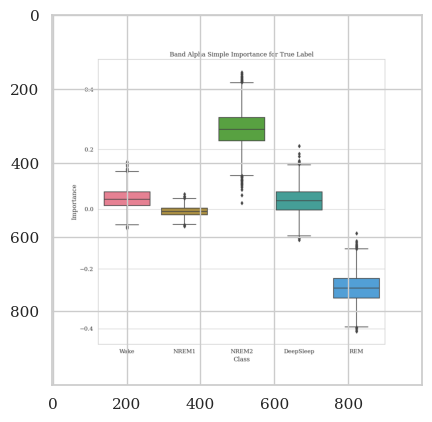

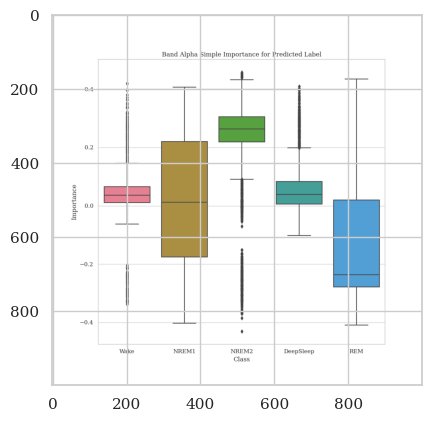

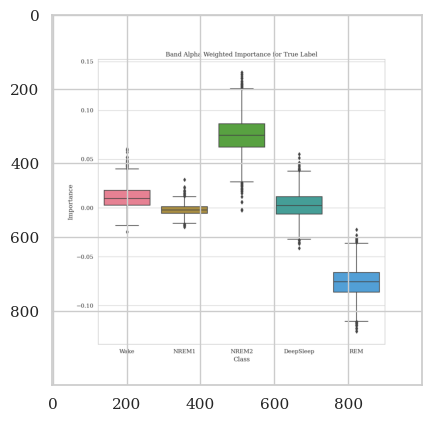

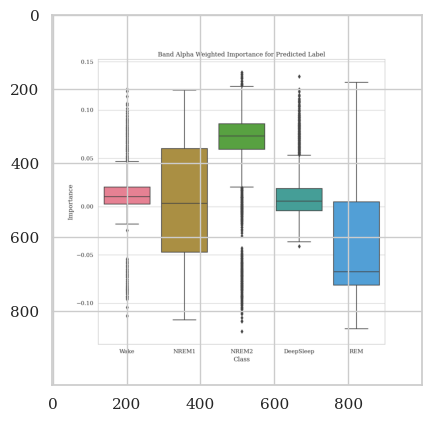

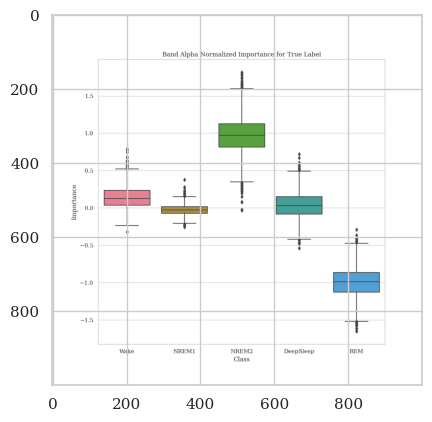

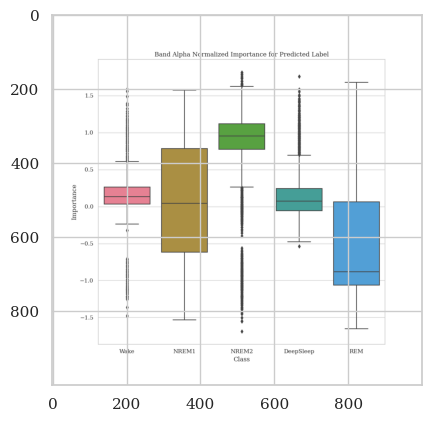

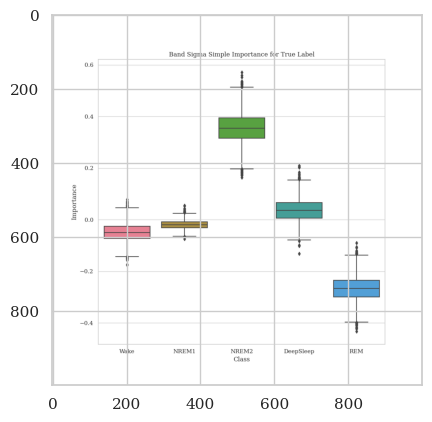

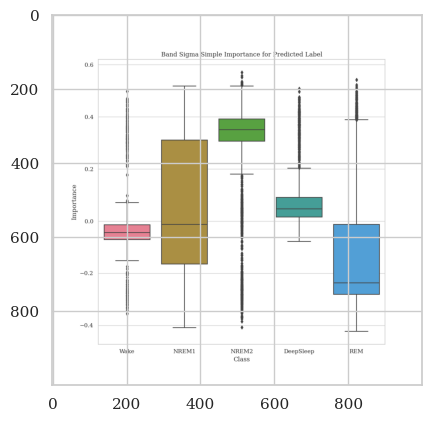

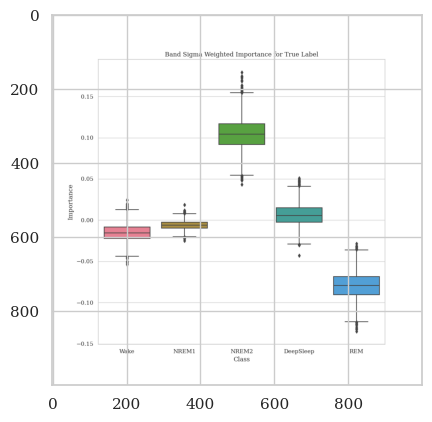

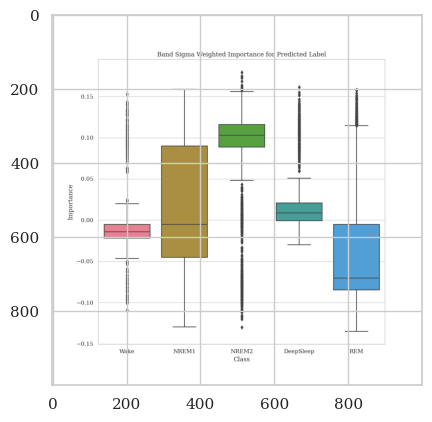

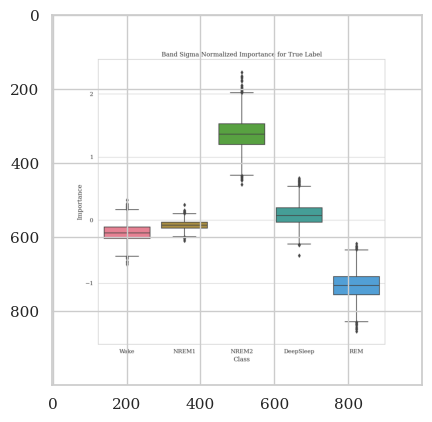

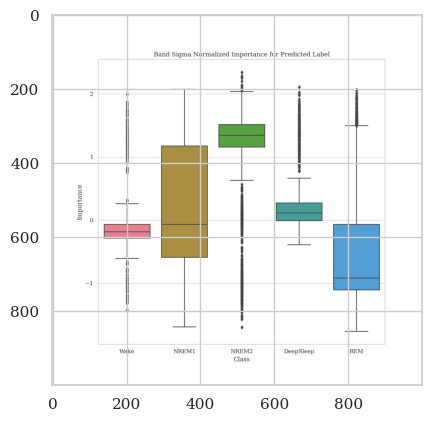

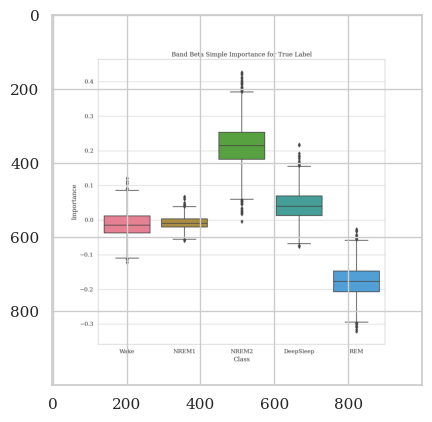

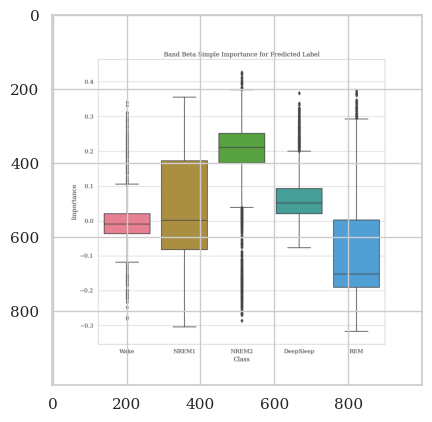

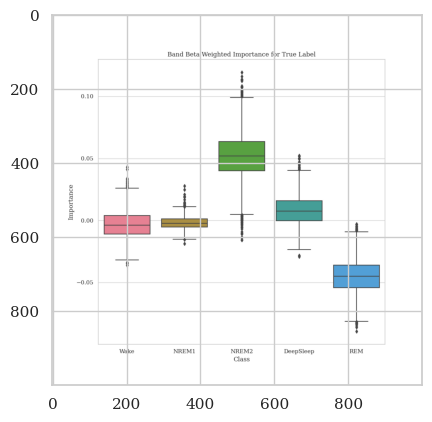

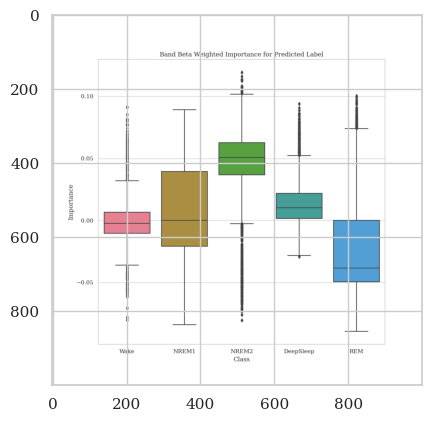

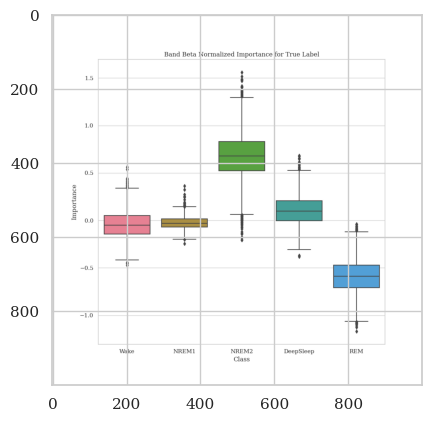

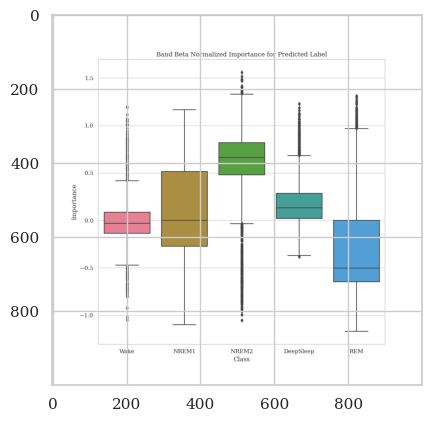

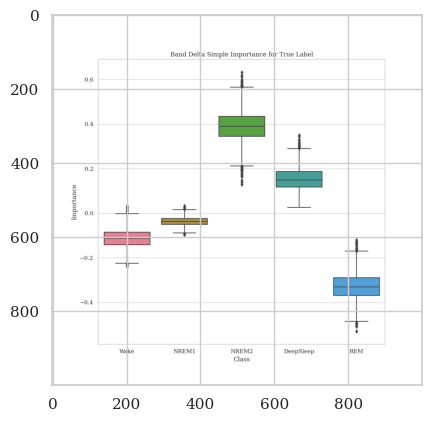

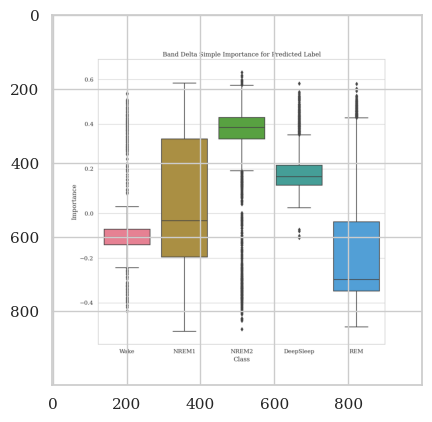

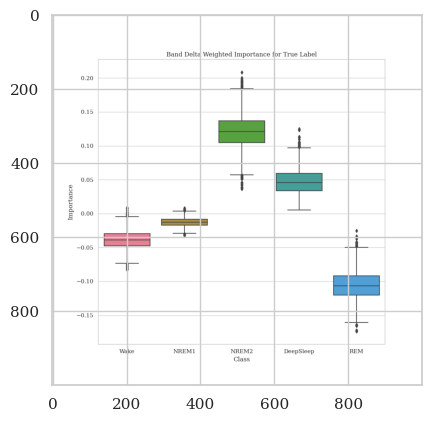

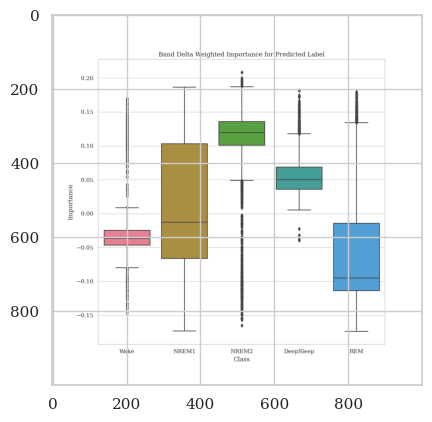

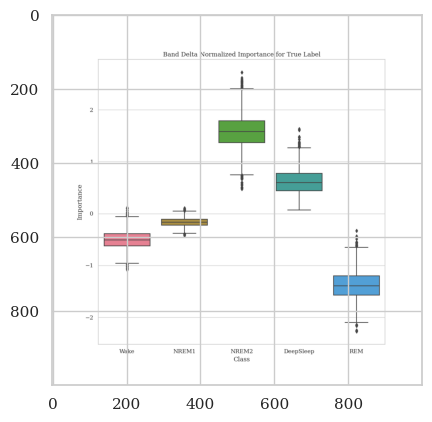

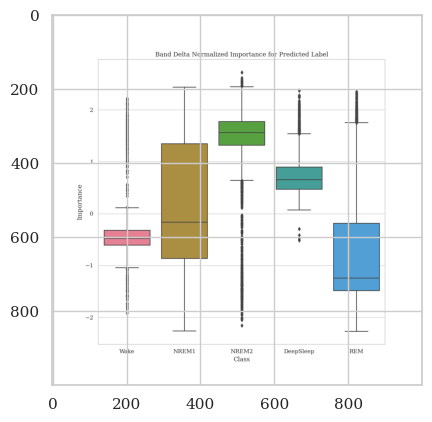

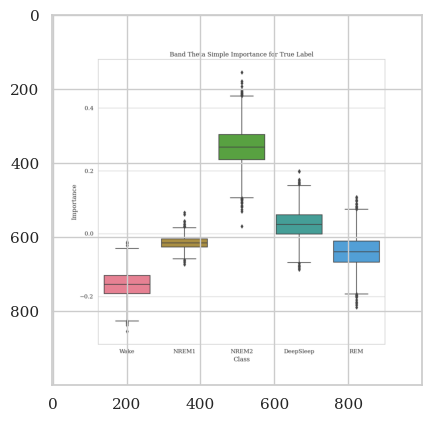

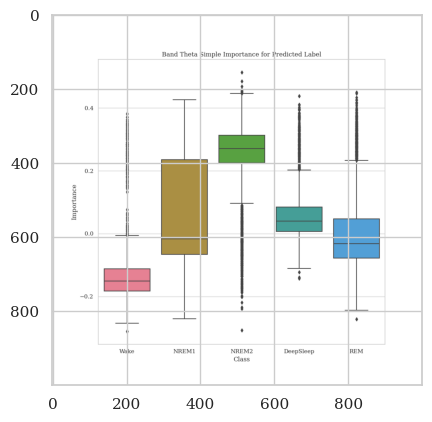

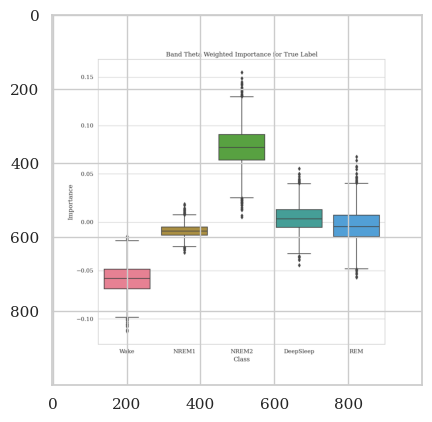

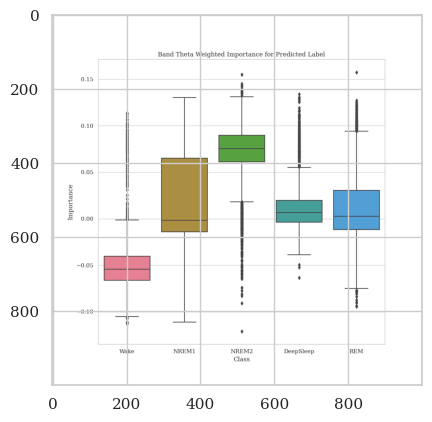

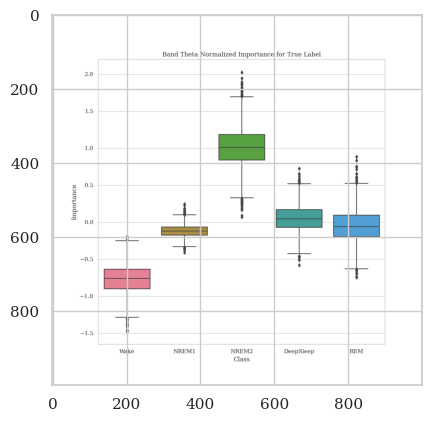

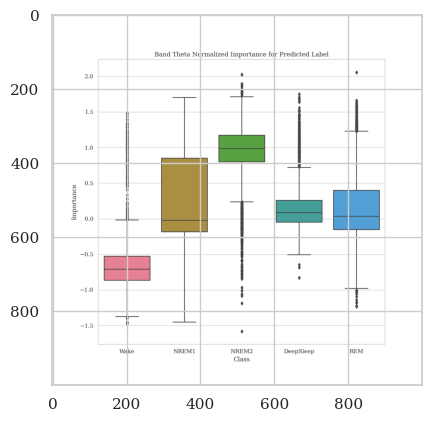

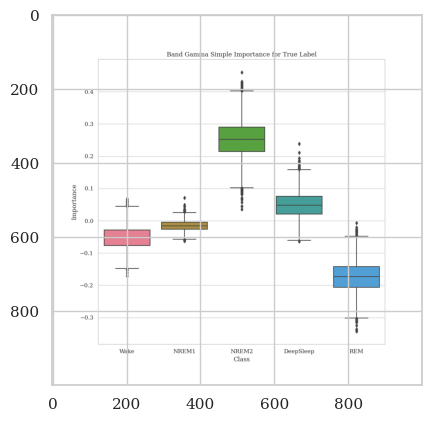

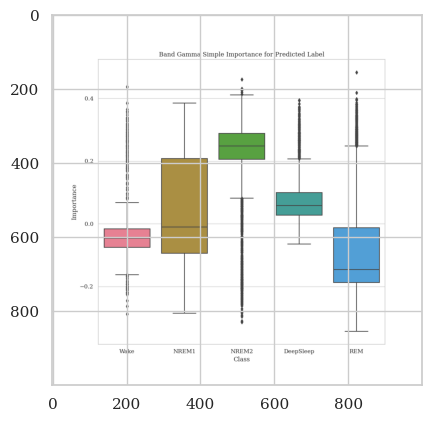

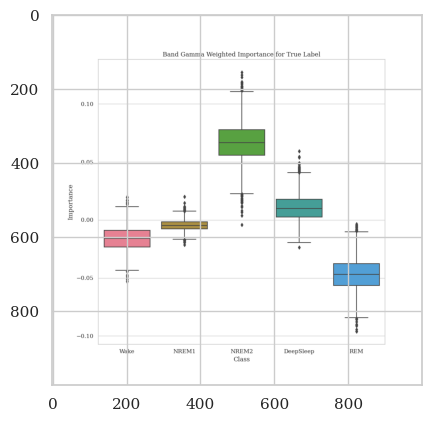

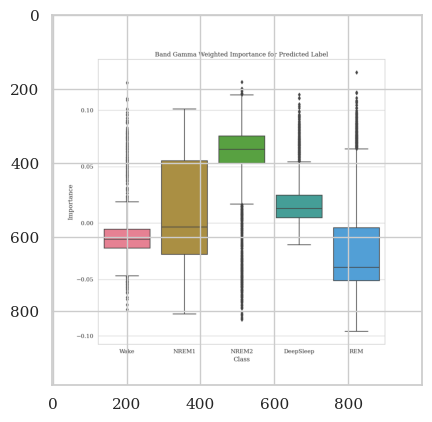

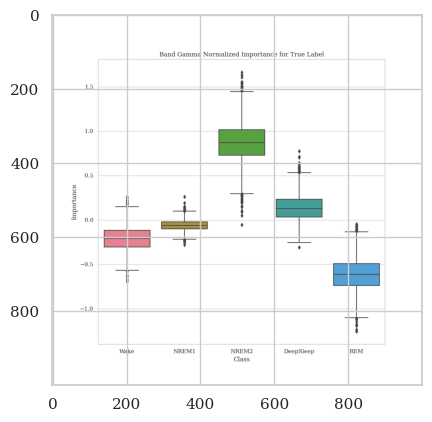

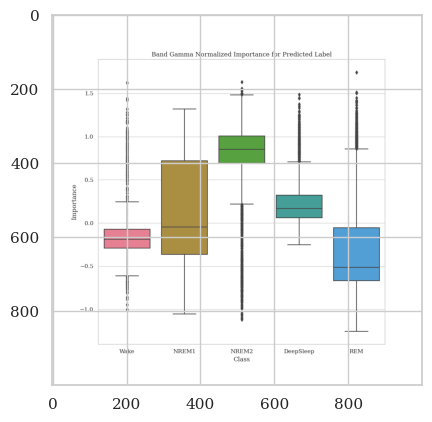

In [3]:
#cambiato Gamma da [30, 50] a [30, 49.5] perche' con un sampling rate di 100hz, il filtro che tagliasse fuori frequenze di 50hz non era applicabile (e.c.)
sleep_bands = [[8, 11.5], [11.5, 15.5], [15.5, 30], [0.5, 4], [4, 8], [30, 49.5]]
sleep_bands_names = ['Alpha', 'Sigma', 'Beta', 'Delta', 'Theta', 'Gamma']

expl.explain(sleep_bands, sleep_bands_names, save_csv= True,  plot_pred = True, plot_true = True, n_jobs = 1)

for i in range(len(sleep_bands)):
    # plot the results of the 0 fold simple importance
    img = mpimg.imread( ckp_path + 'fold=0_true_band=' + sleep_bands_names[i] + '_simple_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    img = mpimg.imread( ckp_path + 'fold=0_pred_band=' + sleep_bands_names[i] + '_simple_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    # plot the results of the 0 fold weighted importance
    img = mpimg.imread( ckp_path + 'fold=0_true_band=' + sleep_bands_names[i] + '_weighted_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    img = mpimg.imread( ckp_path + 'fold=0_pred_band=' + sleep_bands_names[i] + '_weighted_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    # plot the results of the 0 fold normalized importance
    img = mpimg.imread( ckp_path + 'fold=0_true_band=' + sleep_bands_names[i] + '_normalized_importance.png')
    imgplot = plt.imshow(img)
    plt.show()

    img = mpimg.imread( ckp_path + 'fold=0_pred_band=' + sleep_bands_names[i] + '_normalized_importance.png')
    imgplot = plt.imshow(img)
    plt.show()
